In [1]:
# Author: Rob(Linbu Liao)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import pylab as pl
import random
%matplotlib inline

np.random.seed(2)

from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras import backend as K

from skimage.io import imshow

from time import time
from sklearn.manifold import TSNE

sns.set(style='white', context='notebook', palette='deep')

D:\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Customized Functions

In [22]:
def randomShuffle(X, Y):
    idx = [t for t in range(X.shape[0])]
    random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    print()
    print('-' * 36)
    print('dimension of X after synthesis:', X.shape)
    print('dimension of Y after synthesis', Y.shape)
    print('label after shuffle:', '\n', DataFrame(Y).head())
    print('-' * 36)
    return X, Y

## Load Data

In [9]:
# Load the data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [10]:
print(train.shape)
train.head(4)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

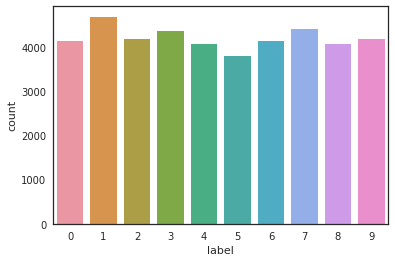

In [3]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## TSNE and Visualization

In [6]:
t0 = time()
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)
result = tsne.fit_transform(X_train)
t1 = time()
print(result)
print("consumed time : ", t1 - t0, "s")

[[-669.9455   -647.0671  ]
 [1681.529    -365.19952 ]
 [-878.2222   -321.88608 ]
 ...
 [ 305.7783    969.99915 ]
 [ 331.1953     58.556908]
 [-364.85324   406.5826  ]]
consumed time :  3596.8673453330994 s


In [12]:
print(result.shape)
np.save("data/TSNE_result.npy", result)

(42000, 2)


In [13]:
result = np.load("data/TSNE_result.npy")
print(result.shape)

(42000, 2)


In [19]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig


------------------------------------
dimension of X after synthesis: (42000, 2)
dimension of Y after synthesis (42000,)
label after shuffle: 
    0
0  6
1  1
2  0
3  7
4  9
------------------------------------


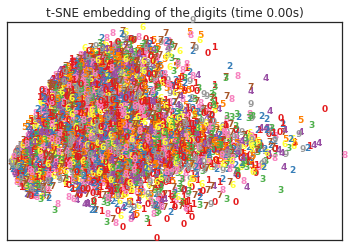

In [28]:
label = np.array(Y_train)
result, label = randomShuffle(result, label)
t0 = time()
fig = plot_embedding(result[0:5000,:], label[0:5000], 't-SNE embedding of the digits (time %.2fs)'% (time() - t0))
plt.show(fig)

## Normalization

In [6]:
X_train = X_train / 255.0
test = test / 255.0

## One-hot

In [7]:
Y_train_soft = to_categorical(Y_train, 10)

In [8]:
X = X_train
Y_soft = Y_train_soft

In [9]:
Y_train_soft[0]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## Data Segmentation
__For simplicity，仅将数据集分割为训练集和验证集__

训练集0.8， 测试集0.2。

后续如果存在线下和线上结果差异较大的情况下可改进数据集切分方式。

In [10]:
random_seed = 2

X_train, X_val, Y_train_soft, Y_val_soft = train_test_split(X_train, Y_train_soft, test_size = 0.2, random_state=random_seed)

In [11]:
Y_train = np.argmax(Y_train_soft, 1)
Y_val = np.argmax(Y_val_soft, 1)

In [12]:
Y_val_soft[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

## Reshape Data

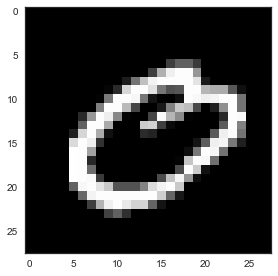

In [13]:
ix = random.randint(0, len(X_train) - 1)
t = np.array(X_train)[ix,].reshape(28,28)
imshow(t)

In [14]:
def imageConvert(data_in):
    
    data_in = np.array(data_in)
    dim = data_in.shape
    change = int(np.sqrt(dim[1]))
    data_out = data_in.reshape(dim[0], change, change, 1)
    
    return data_out

In [15]:
X_image = imageConvert(X)
X_train_image = imageConvert(X_train)
X_val_image = imageConvert(X_val)
test_image = imageConvert(test)

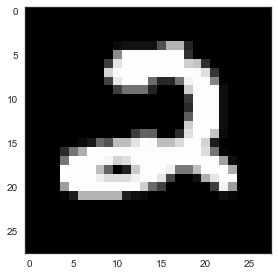

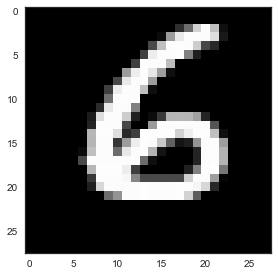

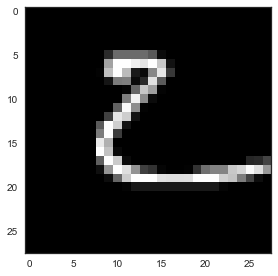

In [16]:
imshow(np.squeeze(test_image[0]))
plt.show()
imshow(np.squeeze(X_val_image[0]))
plt.show()
imshow(np.squeeze(X_train_image[0]))
plt.show()

## Softmax Regression(Tensorflow)

In [17]:
batch_size = 64

def generatebatch(X, Y , n_examples, batch_size):
    for batch_i in range(n_examples // batch_size):
        start = batch_i * batch_size
        end = start + batch_size
        batch_xs = X[start:end, :]
        batch_ys = Y[start:end]
        yield batch_xs, batch_ys

In [105]:
tf.reset_default_graph()
tf_X = tf.placeholder(tf.float32, [None, 784])
tf_Y = tf.placeholder(tf.float32, [None, 10])

tf_W1 = tf.Variable(tf.random_normal([784, 10]))
tf_b1 = tf.Variable(tf.random_normal([1, 10]))

pred = tf.nn.softmax(tf.matmul(tf_X, tf_W1) + tf_b1)

loss = -tf.reduce_sum(tf_Y * tf.log(tf.clip_by_value(pred, 1e-11, 1.0)))

In [74]:
train_step = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

In [75]:
y_pred = tf.arg_max(pred, 1)

bool_pred = tf.equal(tf.argmax(tf_Y, 1), y_pred)

accuracy = tf.reduce_mean(tf.cast(bool_pred, tf.float32))

In [78]:
#可以看到迭代200次左右的效果最好，验证集的准确率可以达到0.9125
#200百次之后继续迭代的话就开始过拟合了
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(1200):
        
        for batch_xs, batch_ys in generatebatch(np.array(X_train), np.array(Y_train_soft), Y_train_soft.shape[0], batch_size):
            sess.run(train_step, feed_dict = {tf_X:batch_xs, tf_Y:batch_ys})
        
        res_train = sess.run(accuracy, feed_dict = {tf_X : X_train, tf_Y: Y_train_soft})
        res_val = sess.run(accuracy, feed_dict = {tf_X : X_val, tf_Y: Y_val_soft})
        print(epoch, ' : ', 'train:', res_train, ', val:', res_val)

0  :  train: 0.546191 , val: 0.543809
1  :  train: 0.719107 , val: 0.707143
2  :  train: 0.784315 , val: 0.773452
3  :  train: 0.818184 , val: 0.80381
4  :  train: 0.838898 , val: 0.826071
5  :  train: 0.853987 , val: 0.84
6  :  train: 0.863451 , val: 0.850476
7  :  train: 0.871755 , val: 0.859643
8  :  train: 0.876874 , val: 0.865476
9  :  train: 0.881725 , val: 0.868691
10  :  train: 0.886309 , val: 0.874167
11  :  train: 0.890326 , val: 0.878453
12  :  train: 0.893451 , val: 0.881429
13  :  train: 0.89613 , val: 0.883572
14  :  train: 0.898065 , val: 0.884643
15  :  train: 0.900773 , val: 0.886429
16  :  train: 0.902588 , val: 0.887024
17  :  train: 0.904344 , val: 0.888929
18  :  train: 0.905713 , val: 0.889643
19  :  train: 0.90735 , val: 0.891191
20  :  train: 0.90869 , val: 0.891786
21  :  train: 0.910029 , val: 0.892381
22  :  train: 0.911398 , val: 0.893095
23  :  train: 0.91232 , val: 0.893691
24  :  train: 0.913243 , val: 0.894524
25  :  train: 0.914344 , val: 0.895953
26  :

210  :  train: 0.948838 , val: 0.912619
211  :  train: 0.948987 , val: 0.9125
212  :  train: 0.949076 , val: 0.9125
213  :  train: 0.949047 , val: 0.912381
214  :  train: 0.949047 , val: 0.912262
215  :  train: 0.949076 , val: 0.912262
216  :  train: 0.949136 , val: 0.912381
217  :  train: 0.949195 , val: 0.9125
218  :  train: 0.949195 , val: 0.9125
219  :  train: 0.949195 , val: 0.912381
220  :  train: 0.949106 , val: 0.912381
221  :  train: 0.949195 , val: 0.912262
222  :  train: 0.949225 , val: 0.912262
223  :  train: 0.949285 , val: 0.911905
224  :  train: 0.949285 , val: 0.911786
225  :  train: 0.949314 , val: 0.911786
226  :  train: 0.949374 , val: 0.911667
227  :  train: 0.949433 , val: 0.911548
228  :  train: 0.949463 , val: 0.911548
229  :  train: 0.949433 , val: 0.911429
230  :  train: 0.949463 , val: 0.911429
231  :  train: 0.949433 , val: 0.911429
232  :  train: 0.949463 , val: 0.91131
233  :  train: 0.949523 , val: 0.91131
234  :  train: 0.949552 , val: 0.91131
235  :  tra

417  :  train: 0.952261 , val: 0.909405
418  :  train: 0.952231 , val: 0.909405
419  :  train: 0.952231 , val: 0.909405
420  :  train: 0.952231 , val: 0.909286
421  :  train: 0.952231 , val: 0.909286
422  :  train: 0.952291 , val: 0.909405
423  :  train: 0.952291 , val: 0.909405
424  :  train: 0.952291 , val: 0.909405
425  :  train: 0.95235 , val: 0.909405
426  :  train: 0.95235 , val: 0.909286
427  :  train: 0.95235 , val: 0.909286
428  :  train: 0.95235 , val: 0.909286
429  :  train: 0.95238 , val: 0.909167
430  :  train: 0.95238 , val: 0.909167
431  :  train: 0.95238 , val: 0.909167
432  :  train: 0.95238 , val: 0.909048
433  :  train: 0.95241 , val: 0.909048
434  :  train: 0.952469 , val: 0.909048
435  :  train: 0.95241 , val: 0.909167
436  :  train: 0.95241 , val: 0.909167
437  :  train: 0.95241 , val: 0.909286
438  :  train: 0.95238 , val: 0.909286
439  :  train: 0.95241 , val: 0.909524
440  :  train: 0.95241 , val: 0.909524
441  :  train: 0.95241 , val: 0.909643
442  :  train: 0

623  :  train: 0.953987 , val: 0.908453
624  :  train: 0.954017 , val: 0.908453
625  :  train: 0.954017 , val: 0.908333
626  :  train: 0.954017 , val: 0.908333
627  :  train: 0.953987 , val: 0.908333
628  :  train: 0.954017 , val: 0.908334
629  :  train: 0.954017 , val: 0.908334
630  :  train: 0.954017 , val: 0.908334
631  :  train: 0.954017 , val: 0.908333
632  :  train: 0.954106 , val: 0.908333
633  :  train: 0.954106 , val: 0.908334
634  :  train: 0.954106 , val: 0.908333
635  :  train: 0.954106 , val: 0.908334
636  :  train: 0.954136 , val: 0.908334
637  :  train: 0.954136 , val: 0.908333
638  :  train: 0.954136 , val: 0.908214
639  :  train: 0.954136 , val: 0.908214
640  :  train: 0.954136 , val: 0.908095
641  :  train: 0.954136 , val: 0.908095
642  :  train: 0.954166 , val: 0.908095
643  :  train: 0.954136 , val: 0.908095
644  :  train: 0.954136 , val: 0.907976
645  :  train: 0.954136 , val: 0.907976
646  :  train: 0.954136 , val: 0.907976
647  :  train: 0.954136 , val: 0.907976


829  :  train: 0.95488 , val: 0.906072
830  :  train: 0.95488 , val: 0.905953
831  :  train: 0.95488 , val: 0.905953
832  :  train: 0.95488 , val: 0.905953
833  :  train: 0.95488 , val: 0.905953
834  :  train: 0.95488 , val: 0.905953
835  :  train: 0.95488 , val: 0.905953
836  :  train: 0.95491 , val: 0.905953
837  :  train: 0.95491 , val: 0.905834
838  :  train: 0.95488 , val: 0.905833
839  :  train: 0.95488 , val: 0.905834
840  :  train: 0.95488 , val: 0.905833
841  :  train: 0.95488 , val: 0.905833
842  :  train: 0.95491 , val: 0.905834
843  :  train: 0.954939 , val: 0.905833
844  :  train: 0.954939 , val: 0.905833
845  :  train: 0.95491 , val: 0.905834
846  :  train: 0.95491 , val: 0.905834
847  :  train: 0.95491 , val: 0.905834
848  :  train: 0.954939 , val: 0.905834
849  :  train: 0.954939 , val: 0.905834
850  :  train: 0.954939 , val: 0.905834
851  :  train: 0.954939 , val: 0.905833
852  :  train: 0.954939 , val: 0.905834
853  :  train: 0.954939 , val: 0.905953
854  :  train: 0.

1034  :  train: 0.955624 , val: 0.904643
1035  :  train: 0.955624 , val: 0.904643
1036  :  train: 0.955654 , val: 0.904643
1037  :  train: 0.955654 , val: 0.904643
1038  :  train: 0.955654 , val: 0.904643
1039  :  train: 0.955654 , val: 0.904643
1040  :  train: 0.955654 , val: 0.904524
1041  :  train: 0.955654 , val: 0.904524
1042  :  train: 0.955654 , val: 0.904524
1043  :  train: 0.955654 , val: 0.904524
1044  :  train: 0.955654 , val: 0.904524
1045  :  train: 0.955654 , val: 0.904405
1046  :  train: 0.955654 , val: 0.904048
1047  :  train: 0.955654 , val: 0.904048
1048  :  train: 0.955654 , val: 0.904048
1049  :  train: 0.955654 , val: 0.904048
1050  :  train: 0.955654 , val: 0.904048
1051  :  train: 0.955654 , val: 0.904048
1052  :  train: 0.955654 , val: 0.904048
1053  :  train: 0.955683 , val: 0.904167
1054  :  train: 0.955683 , val: 0.904167
1055  :  train: 0.955683 , val: 0.904167
1056  :  train: 0.955683 , val: 0.904167
1057  :  train: 0.955683 , val: 0.904167
1058  :  train: 

In [ ]:
output = y_pred.eval(feed_dict = {tf_X:test})

## Fully-connected Neural Network

In [15]:
def FCNN1(input_shape):
    
    X_input = Input(input_shape)
    
    X = Dense(700, init = 'glorot_normal', activation = 'relu', name = 'fcl1')(X_input)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    
    X = Dense(450, init = 'glorot_normal', activation = 'relu', name = 'fcl2')(X)
    X = BatchNormalization(axis = 1, name = 'bn3')(X)
    
    X = Dense(100, init = 'glorot_normal', activation = 'relu', name = 'fcl3')(X)
    X = BatchNormalization(axis = 1, name = 'bn5')(X)
    
    X = Dense(60, init = 'glorot_normal', activation = 'relu', name = 'fcl4')(X)
    X = BatchNormalization(axis = 1, name = 'bn6')(X)
    
    X = Dense(10, init = 'glorot_normal', activation = 'softmax', name = 'fc5')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'FCNN1')
    
    return model

In [16]:
model1 = FCNN1((784,))

C:\Users\coolb\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(700, activation="relu", name="fcl1", kernel_initializer="glorot_normal")`
  """
C:\Users\coolb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(450, activation="relu", name="fcl2", kernel_initializer="glorot_normal")`
  
C:\Users\coolb\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", name="fcl3", kernel_initializer="glorot_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\coolb\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(60, activation="relu", name="fcl4", kernel_initializer="glorot_normal")`
  
C:\Users\coolb\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense`

In [17]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)

In [18]:
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [21]:
earlystopper = EarlyStopping(patience=5, verbose=1)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [79]:
history = model1.fit(x = X_train, y = Y_train_soft, epochs = 120, batch_size = 64, validation_data = (X_val, Y_val_soft)
           , verbose = 30
           , callbacks = [learning_rate_reduction])

Train on 33600 samples, validate on 8400 samples
Epoch 1/120
Epoch 2/120
Epoch 3/120
Epoch 4/120
Epoch 5/120
Epoch 6/120
Epoch 7/120
Epoch 8/120
Epoch 9/120
Epoch 10/120
Epoch 11/120
Epoch 12/120
Epoch 13/120
Epoch 14/120
Epoch 15/120
Epoch 16/120
Epoch 17/120
Epoch 18/120
Epoch 19/120
Epoch 20/120
Epoch 21/120
Epoch 22/120
Epoch 23/120
Epoch 24/120
Epoch 25/120
Epoch 26/120
Epoch 27/120
Epoch 28/120
Epoch 29/120
Epoch 30/120
Epoch 31/120
Epoch 32/120
Epoch 33/120
Epoch 34/120
Epoch 35/120
Epoch 36/120
Epoch 37/120
Epoch 38/120
Epoch 39/120
Epoch 40/120
Epoch 41/120
Epoch 42/120
Epoch 43/120
Epoch 44/120
Epoch 45/120
Epoch 46/120
Epoch 47/120
Epoch 48/120
Epoch 49/120
Epoch 50/120
Epoch 51/120
Epoch 52/120
Epoch 53/120
Epoch 54/120
Epoch 55/120
Epoch 56/120
Epoch 57/120
Epoch 58/120
Epoch 59/120
Epoch 60/120
Epoch 61/120
Epoch 62/120
Epoch 63/120
Epoch 64/120
Epoch 65/120
Epoch 66/120
Epoch 67/120
Epoch 68/120
Epoch 69/120
Epoch 70/120
Epoch 71/120
Epoch 72/120
Epoch 73/120
Epoch 74/12

In [80]:
model1.evaluate(x = X_val, y = Y_val_soft)

8400/8400 [==============================] - 1s 118us/step


[0.087430092378856766, 0.98321428571428571]

7


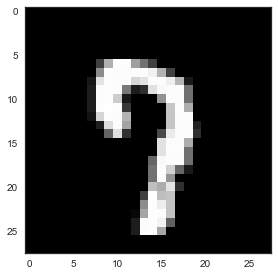

In [81]:
ix = random.randint(0, len(X_val) - 1)
t = np.squeeze(model1.predict(X_val[ix: (ix + 1)]))
print(int(np.where(t == np.max(t))[0]))
imshow(np.squeeze(X_val_image[ix]))

In [82]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
fcl1 (Dense)                 (None, 700)               549500    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 700)               2800      
_________________________________________________________________
fcl2 (Dense)                 (None, 450)               315450    
_________________________________________________________________
bn3 (BatchNormalization)     (None, 450)               1800      
_________________________________________________________________
fcl3 (Dense)                 (None, 100)               45100     
_________________________________________________________________
bn5 (BatchNormalization)     (None, 100)               400       
__________

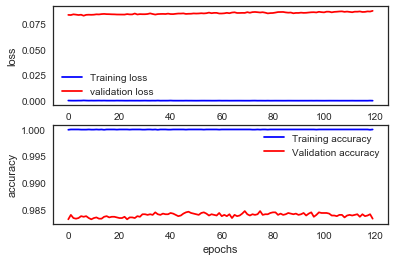

In [83]:
# Plot the loss and accuracy curves for training and validation
# 从结果可以看出人工神经网络有明显的过拟合
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Convolutional Neural Network(copied from [Yassine Ghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6))

In [27]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides = 2))
model2.add(Dropout(0.25))


model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))


model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation = "softmax"))

In [28]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [29]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [30]:
# Compile the model
model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [33]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [55]:
epochs = 120 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 64

In [84]:
# Without data augmentation i obtained an accuracy of 0.98114
history = model2.fit(X_train_image, Y_train_soft, batch_size = batch_size, epochs = epochs
                     , verbose = 120 
                     , validation_data = (X_val_image, Y_val_soft), callbacks = [learning_rate_reduction])

Train on 33600 samples, validate on 8400 samples
Epoch 1/120
Epoch 2/120
Epoch 3/120
Epoch 4/120
Epoch 5/120
Epoch 6/120
Epoch 7/120
Epoch 8/120
Epoch 9/120
Epoch 10/120
Epoch 11/120
Epoch 12/120
Epoch 13/120
Epoch 14/120
Epoch 15/120
Epoch 16/120
Epoch 17/120
Epoch 18/120
Epoch 19/120
Epoch 20/120
Epoch 21/120
Epoch 22/120
Epoch 23/120
Epoch 24/120
Epoch 25/120
Epoch 26/120
Epoch 27/120
Epoch 28/120
Epoch 29/120
Epoch 30/120
Epoch 31/120
Epoch 32/120
Epoch 33/120
Epoch 34/120
Epoch 35/120
Epoch 36/120
Epoch 37/120
Epoch 38/120
Epoch 39/120
Epoch 40/120
Epoch 41/120
Epoch 42/120
Epoch 43/120
Epoch 44/120
Epoch 45/120
Epoch 46/120
Epoch 47/120
Epoch 48/120
Epoch 49/120
Epoch 50/120
Epoch 51/120
Epoch 52/120
Epoch 53/120
Epoch 54/120
Epoch 55/120
Epoch 56/120
Epoch 57/120
Epoch 58/120
Epoch 59/120
Epoch 60/120
Epoch 61/120
Epoch 62/120
Epoch 63/120
Epoch 64/120
Epoch 65/120
Epoch 66/120
Epoch 67/120
Epoch 68/120
Epoch 69/120
Epoch 70/120
Epoch 71/120
Epoch 72/120
Epoch 73/120
Epoch 74/12

In [85]:
model2.evaluate(x = X_val_image, y = Y_val_soft)

8400/8400 [==============================] - 1s 98us/step


[0.028106924291305242, 0.99404761904761907]

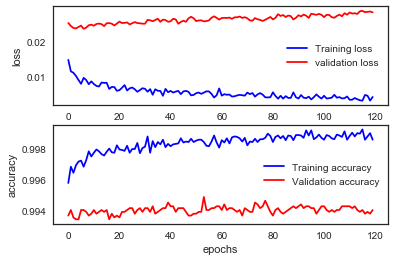

In [86]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Data Augmentation

In [51]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_image)

In [57]:
# Fit the model
history = model2.fit_generator(datagen.flow(X_train_image,Y_train_soft, batch_size=batch_size)
                              , epochs = epochs, validation_data = (X_val_image,Y_val_soft)
                              , steps_per_epoch=X_train_image.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/120
525/525 [==============================] - 6s 12ms/step - loss: 0.1370 - acc: 0.9628 - val_loss: 0.0280 - val_acc: 0.9930
Epoch 2/120
525/525 [==============================] - 6s 11ms/step - loss: 0.1358 - acc: 0.9629 - val_loss: 0.0286 - val_acc: 0.9927
Epoch 3/120
525/525 [==============================] - 6s 11ms/step - loss: 0.1329 - acc: 0.9627 - val_loss: 0.0288 - val_acc: 0.9925
Epoch 4/120
525/525 [==============================] - 6s 11ms/step - loss: 0.1317 - acc: 0.9644 - val_loss: 0.0285 - val_acc: 0.9927
Epoch 5/120
525/525 [==============================] - 6s 11ms/step - loss: 0.1188 - acc: 0.9669 - val_loss: 0.0291 - val_acc: 0.9930
Epoch 6/120
525/525 [==============================] - 6s 11ms/step - loss: 0.1194 - acc: 0.9669 - val_loss: 0.0288 - val_acc: 0.9931
Epoch 7/120
525/525 [==============================] - 6s 12ms/step - loss: 0.1228 - acc: 0.9646 - val_loss: 0.0296 - val_acc: 0.9923
Epoch 8/120
525/525 [==============================] - 6s 11ms

Epoch 62/120
525/525 [==============================] - 6s 11ms/step - loss: 0.0650 - acc: 0.9811 - val_loss: 0.0333 - val_acc: 0.9923
Epoch 63/120
525/525 [==============================] - 6s 11ms/step - loss: 0.0693 - acc: 0.9805 - val_loss: 0.0324 - val_acc: 0.9926
Epoch 64/120
525/525 [==============================] - 6s 11ms/step - loss: 0.0724 - acc: 0.9797 - val_loss: 0.0319 - val_acc: 0.9927
Epoch 65/120
525/525 [==============================] - 6s 11ms/step - loss: 0.0726 - acc: 0.9791 - val_loss: 0.0338 - val_acc: 0.9920
Epoch 66/120
525/525 [==============================] - 6s 11ms/step - loss: 0.0705 - acc: 0.9801 - val_loss: 0.0331 - val_acc: 0.9921
Epoch 67/120
525/525 [==============================] - 6s 11ms/step - loss: 0.0696 - acc: 0.9798 - val_loss: 0.0328 - val_acc: 0.9924
Epoch 68/120
525/525 [==============================] - 6s 11ms/step - loss: 0.0709 - acc: 0.9789 - val_loss: 0.0318 - val_acc: 0.9925
Epoch 69/120
525/525 [==============================] -

### Results and Visualization

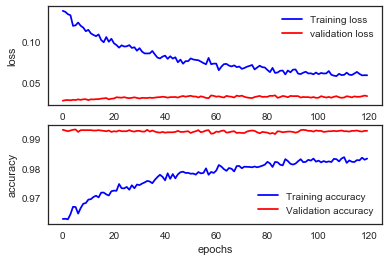

In [58]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [165]:
history.history

{'acc': [0.9419642857142857],
 'loss': [0.19180845113338105],
 'lr': [0.001],
 'val_acc': [0.9800967261904762],
 'val_loss': [0.06315612107781428]}

### output(all_data)

In [32]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


datagen.fit(X_train_image)

# Fit the model
history = model2.fit_generator(datagen.flow(X_image,Y_soft, batch_size=64)
                              , epochs = 120, validation_data = (X_val_image,Y_val_soft)
                              , steps_per_epoch=X_train_image.shape[0] // 64
                              , callbacks=[learning_rate_reduction])

Epoch 1/120
525/525 [==============================] - 7s 14ms/step - loss: 0.4100 - acc: 0.8688 - val_loss: 0.0522 - val_acc: 0.9827
Epoch 2/120
525/525 [==============================] - 6s 12ms/step - loss: 0.1323 - acc: 0.9599 - val_loss: 0.0449 - val_acc: 0.9867
Epoch 3/120
525/525 [==============================] - 6s 12ms/step - loss: 0.1035 - acc: 0.9691 - val_loss: 0.0468 - val_acc: 0.9851
Epoch 4/120
525/525 [==============================] - 6s 12ms/step - loss: 0.0836 - acc: 0.9753 - val_loss: 0.0330 - val_acc: 0.9896
Epoch 5/120
525/525 [==============================] - 6s 12ms/step - loss: 0.0751 - acc: 0.9767 - val_loss: 0.0364 - val_acc: 0.9889
Epoch 6/120
525/525 [==============================] - 6s 12ms/step - loss: 0.0734 - acc: 0.9788 - val_loss: 0.0252 - val_acc: 0.9918
Epoch 7/120
525/525 [==============================] - 6s 12ms/step - loss: 0.0699 - acc: 0.9799 - val_loss: 0.0279 - val_acc: 0.9912
Epoch 8/120
525/525 [==============================] - 6s 12ms

525/525 [==============================] - 6s 12ms/step - loss: 0.0339 - acc: 0.9896 - val_loss: 0.0139 - val_acc: 0.9975
Epoch 118/120
525/525 [==============================] - 6s 12ms/step - loss: 0.0337 - acc: 0.9910 - val_loss: 0.0133 - val_acc: 0.9971
Epoch 119/120
525/525 [==============================] - 6s 12ms/step - loss: 0.0363 - acc: 0.9901 - val_loss: 0.0133 - val_acc: 0.9974
Epoch 120/120
525/525 [==============================] - 6s 12ms/step - loss: 0.0339 - acc: 0.9903 - val_loss: 0.0130 - val_acc: 0.9974


In [33]:
pred = model2.predict(test_image)

In [34]:
pred = DataFrame(np.argmax(pred, 1))
print(pred.head())
pred.columns = ['Label']
print(pred.shape)
pred.to_csv('output/pred2_aug_all.csv', index_label = 'ImageId')

   0
0  2
1  0
2  9
3  0
4  3
(28000, 1)


## Convolutional Neural Network（inspired from U-net）

In [19]:
K.clear_session()

In [20]:
# Build U-Net model
def my_U_net(h, y, c):
    inputs = Input((h, y, c))
    
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same', name = 'conv1_1') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same', name = 'conv1_2') (c1)  #28
    p1 = MaxPooling2D((2, 2), name = 'conv1_maxpool') (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same', name = 'conv2_1') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same', name = 'conv2_2') (c2) #14
    p2 = MaxPooling2D((2, 2), name = 'conv2_maxpool') (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv3_1') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv3_2') (c3) #7
    p3 = MaxPooling2D((2, 2), name = 'conv3_maxpool') (c3)
    
    u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', name = 'conv4_T') (c3)
    u4 = concatenate([u4, c2], name = 'conv4_C')
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same', name = 'conv4_1') (u4) #14
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same', name = 'conv4_2') (c4)

    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name = 'conv5_T') (c4)
    u5 = concatenate([u5, c1], name = 'conv5_C')
    c5 = Conv2D(8, (3, 3), activation='relu', padding='same', name = 'conv5_1') (u5) #28
    c5 = Conv2D(8, (3, 3), activation='relu', padding='same', name = 'conv5_2') (c5)

    X = Flatten(name = 'fc0')(c5)
    
    X = Dense(2000, init = 'glorot_normal', activation = 'relu', name = 'fc1')(X)
    
    X = Dense(100, init = 'glorot_normal', activation = 'relu', name = 'fc2')(X)
    
    X = Dense(10, init = 'glorot_normal', activation = 'softmax', name = 'fc3')(X)

    model = Model(inputs=inputs, outputs=X)
    
    return model

In [21]:
model3 = my_U_net(28, 28, 1)

C:\Users\coolb\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2000, activation="relu", name="fc1", kernel_initializer="glorot_normal")`
C:\Users\coolb\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", name="fc2", kernel_initializer="glorot_normal")`
C:\Users\coolb\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", name="fc3", kernel_initializer="glorot_normal")`


In [22]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 28, 28, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 28, 28, 8)    584         conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_maxpool (MaxPooling2D)    (None, 14, 14, 8)    0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [23]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

checkpointer = ModelCheckpoint('model/model3.h5', verbose=1, save_best_only=True)

earlystopper = EarlyStopping(patience=5, verbose=1)

In [36]:
history = model3.fit(x = X_train_image, y = Y_train_soft, batch_size=64, epochs=120,
                    validation_data = (X_val_image, Y_val_soft),
                    callbacks=[learning_rate_reduction, checkpointer])

Train on 33600 samples, validate on 8400 samples
Epoch 1/120
33600/33600 [==============================] - 17s 504us/step - loss: 0.1871 - acc: 0.9434 - val_loss: 0.0738 - val_acc: 0.9779

Epoch 00001: val_loss improved from inf to 0.07382, saving model to model/model3.h5
Epoch 2/120
33600/33600 [==============================] - 14s 407us/step - loss: 0.0539 - acc: 0.9837 - val_loss: 0.0526 - val_acc: 0.9842

Epoch 00002: val_loss improved from 0.07382 to 0.05262, saving model to model/model3.h5
Epoch 3/120
33600/33600 [==============================] - 14s 405us/step - loss: 0.0332 - acc: 0.9898 - val_loss: 0.0546 - val_acc: 0.9839

Epoch 00003: val_loss did not improve
Epoch 4/120
33600/33600 [==============================] - 13s 401us/step - loss: 0.0214 - acc: 0.9930 - val_loss: 0.0591 - val_acc: 0.9831

Epoch 00004: val_loss did not improve
Epoch 5/120
33600/33600 [==============================] - 14s 408us/step - loss: 0.0215 - acc: 0.9931 - val_loss: 0.0595 - val_acc: 0.9838

33600/33600 [==============================] - 13s 393us/step - loss: 1.6755e-07 - acc: 1.0000 - val_loss: 0.0808 - val_acc: 0.9900

Epoch 00043: val_loss did not improve
Epoch 44/120
33600/33600 [==============================] - 13s 394us/step - loss: 1.6495e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9900

Epoch 00044: val_loss did not improve
Epoch 45/120
33600/33600 [==============================] - 13s 397us/step - loss: 1.6208e-07 - acc: 1.0000 - val_loss: 0.0811 - val_acc: 0.9900

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00045: val_loss did not improve
Epoch 46/120
33600/33600 [==============================] - 13s 398us/step - loss: 1.5955e-07 - acc: 1.0000 - val_loss: 0.0813 - val_acc: 0.9900

Epoch 00046: val_loss did not improve
Epoch 47/120
33600/33600 [==============================] - 13s 397us/step - loss: 1.5776e-07 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 0.9900

Epoch 00047: val_loss did not improve
Epoch 48/12

33600/33600 [==============================] - 13s 392us/step - loss: 1.1959e-07 - acc: 1.0000 - val_loss: 0.0944 - val_acc: 0.9904

Epoch 00087: val_loss did not improve
Epoch 88/120
33600/33600 [==============================] - 13s 388us/step - loss: 1.1956e-07 - acc: 1.0000 - val_loss: 0.0945 - val_acc: 0.9904

Epoch 00088: val_loss did not improve
Epoch 89/120
33600/33600 [==============================] - 13s 389us/step - loss: 1.1954e-07 - acc: 1.0000 - val_loss: 0.0946 - val_acc: 0.9904

Epoch 00089: val_loss did not improve
Epoch 90/120
33600/33600 [==============================] - 13s 392us/step - loss: 1.1952e-07 - acc: 1.0000 - val_loss: 0.0947 - val_acc: 0.9904

Epoch 00090: val_loss did not improve
Epoch 91/120
33600/33600 [==============================] - 13s 390us/step - loss: 1.1951e-07 - acc: 1.0000 - val_loss: 0.0948 - val_acc: 0.9904

Epoch 00091: val_loss did not improve
Epoch 92/120
33600/33600 [==============================] - 13s 389us/step - loss: 1.1950e-07

In [37]:
pred = model3.predict(test_image)

In [39]:
pred = DataFrame(np.argmax(pred, 1))
print(pred.head())
pred.columns = ['Label']
print(pred.shape)
pred.to_csv('output/pred1.csv', index_label = 'ImageId')

   0
0  2
1  0
2  9
3  0
4  3
(28000, 1)


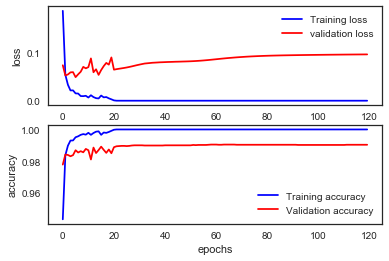

In [40]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [41]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_image)

In [42]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

checkpointer = ModelCheckpoint('model/model3_aug.h5', verbose=1, save_best_only=True)

earlystopper = EarlyStopping(patience=5, verbose=1)

In [44]:
# Fit the model
history = model3.fit_generator(datagen.flow(X_train_image,Y_train_soft, batch_size=64)
                              , epochs = 120, validation_data = (X_val_image,Y_val_soft)
                              , steps_per_epoch=X_train_image.shape[0] // 64
                              , callbacks=[learning_rate_reduction, checkpointer])

Epoch 1/120
525/525 [==============================] - 14s 26ms/step - loss: 0.9188 - acc: 0.8859 - val_loss: 0.0655 - val_acc: 0.9905

Epoch 00001: val_loss improved from inf to 0.06551, saving model to model/model3_aug.h5
Epoch 2/120
525/525 [==============================] - 13s 25ms/step - loss: 0.5390 - acc: 0.9019 - val_loss: 0.0531 - val_acc: 0.9900

Epoch 00002: val_loss improved from 0.06551 to 0.05314, saving model to model/model3_aug.h5
Epoch 3/120
525/525 [==============================] - 13s 25ms/step - loss: 0.4001 - acc: 0.9118 - val_loss: 0.0448 - val_acc: 0.9895

Epoch 00003: val_loss improved from 0.05314 to 0.04482, saving model to model/model3_aug.h5
Epoch 4/120
525/525 [==============================] - 13s 25ms/step - loss: 0.3092 - acc: 0.9190 - val_loss: 0.0405 - val_acc: 0.9894

Epoch 00004: val_loss improved from 0.04482 to 0.04049, saving model to model/model3_aug.h5
Epoch 5/120
525/525 [==============================] - 13s 25ms/step - loss: 0.2753 - acc: 0


Epoch 00038: val_loss improved from 0.03243 to 0.03232, saving model to model/model3_aug.h5
Epoch 39/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0744 - acc: 0.9765 - val_loss: 0.0323 - val_acc: 0.9908

Epoch 00039: val_loss improved from 0.03232 to 0.03227, saving model to model/model3_aug.h5
Epoch 40/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0777 - acc: 0.9771 - val_loss: 0.0320 - val_acc: 0.9911

Epoch 00040: val_loss improved from 0.03227 to 0.03202, saving model to model/model3_aug.h5
Epoch 41/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0747 - acc: 0.9768 - val_loss: 0.0319 - val_acc: 0.9908

Epoch 00041: val_loss improved from 0.03202 to 0.03185, saving model to model/model3_aug.h5
Epoch 42/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0702 - acc: 0.9786 - val_loss: 0.0319 - val_acc: 0.9908

Epoch 00042: val_loss did not improve
Epoch 43/120
525/525 [=======================

525/525 [==============================] - 16s 30ms/step - loss: 0.0314 - acc: 0.9900 - val_loss: 0.0239 - val_acc: 0.9935

Epoch 00119: val_loss did not improve
Epoch 120/120
525/525 [==============================] - 16s 30ms/step - loss: 0.0298 - acc: 0.9906 - val_loss: 0.0240 - val_acc: 0.9931

Epoch 00120: val_loss did not improve


In [45]:
pred = model3.predict(test_image)

In [46]:
pred = DataFrame(np.argmax(pred, 1))
print(pred.head())
pred.columns = ['Label']
print(pred.shape)
pred.to_csv('output/pred1_aug.csv', index_label = 'ImageId')

   0
0  2
1  0
2  9
3  0
4  3
(28000, 1)


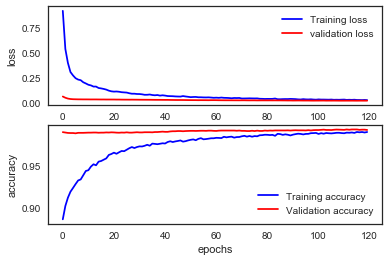

In [47]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

checkpointer = ModelCheckpoint('model/model3_aug.h5', verbose=1, save_best_only=True)

earlystopper = EarlyStopping(patience=5, verbose=1)

datagen.fit(X_train_image)

# Fit the model
history = model3.fit_generator(datagen.flow(X_image,Y_soft, batch_size=64)
                              , epochs = 120, validation_data = (X_val_image,Y_val_soft)
                              , steps_per_epoch=X_train_image.shape[0] // 64
                              , callbacks=[learning_rate_reduction, checkpointer])

Epoch 1/120
525/525 [==============================] - 17s 32ms/step - loss: 0.3119 - acc: 0.9005 - val_loss: 0.0721 - val_acc: 0.9773

Epoch 00001: val_loss improved from inf to 0.07215, saving model to model/model3_aug.h5
Epoch 2/120
525/525 [==============================] - 13s 25ms/step - loss: 0.1039 - acc: 0.9684 - val_loss: 0.0472 - val_acc: 0.9849

Epoch 00002: val_loss improved from 0.07215 to 0.04721, saving model to model/model3_aug.h5
Epoch 3/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0788 - acc: 0.9765 - val_loss: 0.0534 - val_acc: 0.9817

Epoch 00003: val_loss did not improve
Epoch 4/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0639 - acc: 0.9812 - val_loss: 0.0370 - val_acc: 0.9889

Epoch 00004: val_loss improved from 0.04721 to 0.03701, saving model to model/model3_aug.h5
Epoch 5/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0571 - acc: 0.9837 - val_loss: 0.0332 - val_acc: 0.9901

Epoch 0000


Epoch 00040: val_loss did not improve
Epoch 41/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0082 - acc: 0.9974 - val_loss: 0.0022 - val_acc: 0.9996

Epoch 00041: val_loss did not improve
Epoch 42/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0018 - val_acc: 0.9994

Epoch 00042: val_loss improved from 0.00187 to 0.00183, saving model to model/model3_aug.h5
Epoch 43/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0061 - acc: 0.9983 - val_loss: 0.0017 - val_acc: 0.9996

Epoch 00043: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00043: val_loss improved from 0.00183 to 0.00169, saving model to model/model3_aug.h5
Epoch 44/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0065 - acc: 0.9981 - val_loss: 0.0014 - val_acc: 0.9998

Epoch 00044: val_loss improved from 0.00169 to 0.00141, saving model to model/model3_aug.h5
Epoch 45/120
525/52

525/525 [==============================] - 13s 25ms/step - loss: 0.0041 - acc: 0.9986 - val_loss: 0.0010 - val_acc: 0.9998

Epoch 00082: val_loss did not improve
Epoch 83/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0038 - acc: 0.9986 - val_loss: 9.6071e-04 - val_acc: 0.9999

Epoch 00083: val_loss did not improve
Epoch 84/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0040 - acc: 0.9988 - val_loss: 0.0010 - val_acc: 0.9998

Epoch 00084: val_loss did not improve
Epoch 85/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0042 - acc: 0.9988 - val_loss: 9.9117e-04 - val_acc: 0.9999

Epoch 00085: val_loss did not improve
Epoch 86/120
525/525 [==============================] - 13s 25ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 9.3082e-04 - val_acc: 0.9999

Epoch 00086: val_loss improved from 0.00095 to 0.00093, saving model to model/model3_aug.h5
Epoch 87/120
525/525 [==============================] - 13s 25ms/step - 

In [25]:
pred = model3.predict(test_image)

In [26]:
pred = DataFrame(np.argmax(pred, 1))
print(pred.head())
pred.columns = ['Label']
print(pred.shape)
pred.to_csv('output/pred1_aug_all.csv', index_label = 'ImageId')

   0
0  2
1  0
2  9
3  0
4  3
(28000, 1)


### Result

![result.PNG](./result.PNG)

### Load Model

In [49]:
model3 = load_model('model/model3.h5')

In [138]:
model3.evaluate(x = X_val_image, y = Y_val)

8400/8400 [==============================] - 1s 142us/step


[0.053531539481735398, 0.98642857142857143]

In [139]:
t = model3.predict(X_val_image[0:2])
print(t)
print(np.argmax(t, axis = 1))

[[  1.53133513e-11   1.64887461e-12   4.65488412e-17   8.00490710e-16
    1.20291268e-11   3.84635379e-12   1.00000000e+00   4.66766902e-17
    1.95581030e-12   1.89850588e-12]
 [  7.95326027e-11   3.92416958e-12   2.98145064e-10   6.88337668e-12
    6.71141956e-04   6.77932988e-10   4.65753477e-12   6.82036407e-05
    2.44167296e-07   9.99260366e-01]]
[6 9]


7


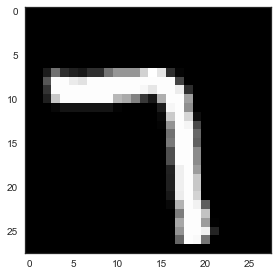

In [140]:
ix = random.randint(0, len(X_val) - 1)
t = np.squeeze(model3.predict(X_val_image[ix: (ix + 1)]))
print(np.argmax(t))
imshow(np.squeeze(X_val_image[ix]))

In [141]:
model3_aug = load_model('model/model3_aug.h5')

In [142]:
model3.evaluate(x = X_val_image, y = Y_val)

8400/8400 [==============================] - 1s 131us/step


[0.053531539481735398, 0.98642857142857143]

## SVM

In [163]:
clf = svm.SVC()

clf.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [183]:
pred_val = clf.predict(X_val)
pred_train = clf.predict(X_train)

[7]


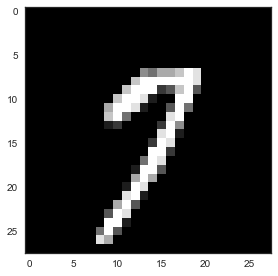

In [182]:
ix = np.random.randint(0, len(X_val))
t = clf.predict(np.array(X_val)[ix : (ix + 1)])
print(t)
imshow(np.squeeze(np.array(X_val_image[ix : (ix + 1)])))

In [184]:
t1 = sum(pred_train == Y_train) / len(Y_train)
t2 = sum(pred == Y_val) / len(Y_val)
print(t1)
print(t2)

0.938541666667
0.934880952381


## XGBOOST

In [196]:
def my_accuracy(preds, dtrain):
    label = dtrain.get_label()
    
    accuracy = float(sum(label == preds) / len(label))
    
    return 'accuracy', accuracy

In [197]:
#7700次左右验证集的准确率达到了0.977
dtrain = xgb.DMatrix(data = X_train, label = Y_train)
dval = xgb.DMatrix(data = X_val, label = Y_val)

params = {'booster':'gbtree',
          'objective':'multi:softmax',
          'max_delta_step':1,
          'max_depth':6,
          'lambda':1,
          'subsample':0.8,
          'colsample_bytree':0.8,
          'min_child_weight':2,
          'eta':0.01,
          'silent':0,
          'num_class':10}

watchList = [(dtrain, 'train'), (dval, 'dval')]

In [198]:
bst = xgb.train(params, dtrain, num_boost_round = 8000, evals = watchList, feval = my_accuracy)

[0]	train-merror:0.200774	dval-merror:0.223929	train-accuracy:0.799226	dval-accuracy:0.776071
[1]	train-merror:0.149226	dval-merror:0.175714	train-accuracy:0.850774	dval-accuracy:0.824286
[2]	train-merror:0.120595	dval-merror:0.147024	train-accuracy:0.879405	dval-accuracy:0.852976
[3]	train-merror:0.116845	dval-merror:0.142381	train-accuracy:0.883155	dval-accuracy:0.857619
[4]	train-merror:0.105476	dval-merror:0.13119	train-accuracy:0.894524	dval-accuracy:0.86881
[5]	train-merror:0.102054	dval-merror:0.128333	train-accuracy:0.897946	dval-accuracy:0.871667
[6]	train-merror:0.102232	dval-merror:0.127738	train-accuracy:0.897768	dval-accuracy:0.872262
[7]	train-merror:0.100714	dval-merror:0.127024	train-accuracy:0.899286	dval-accuracy:0.872976
[8]	train-merror:0.099792	dval-merror:0.126786	train-accuracy:0.900208	dval-accuracy:0.873214
[9]	train-merror:0.100238	dval-merror:0.12631	train-accuracy:0.899762	dval-accuracy:0.87369
[10]	train-merror:0.095744	dval-merror:0.123214	train-accuracy:0

[88]	train-merror:0.066756	dval-merror:0.091786	train-accuracy:0.933244	dval-accuracy:0.908214
[89]	train-merror:0.066667	dval-merror:0.091548	train-accuracy:0.933333	dval-accuracy:0.908452
[90]	train-merror:0.066726	dval-merror:0.091667	train-accuracy:0.933274	dval-accuracy:0.908333
[91]	train-merror:0.066607	dval-merror:0.091786	train-accuracy:0.933393	dval-accuracy:0.908214
[92]	train-merror:0.066488	dval-merror:0.09119	train-accuracy:0.933512	dval-accuracy:0.90881
[93]	train-merror:0.06628	dval-merror:0.091429	train-accuracy:0.93372	dval-accuracy:0.908571
[94]	train-merror:0.066161	dval-merror:0.091548	train-accuracy:0.933839	dval-accuracy:0.908452
[95]	train-merror:0.065982	dval-merror:0.091429	train-accuracy:0.934018	dval-accuracy:0.908571
[96]	train-merror:0.065952	dval-merror:0.09131	train-accuracy:0.934048	dval-accuracy:0.90869
[97]	train-merror:0.065863	dval-merror:0.09131	train-accuracy:0.934137	dval-accuracy:0.90869
[98]	train-merror:0.065744	dval-merror:0.090476	train-accu

[175]	train-merror:0.051577	dval-merror:0.074881	train-accuracy:0.948423	dval-accuracy:0.925119
[176]	train-merror:0.05125	dval-merror:0.074286	train-accuracy:0.94875	dval-accuracy:0.925714
[177]	train-merror:0.05122	dval-merror:0.074405	train-accuracy:0.94878	dval-accuracy:0.925595
[178]	train-merror:0.051101	dval-merror:0.074524	train-accuracy:0.948899	dval-accuracy:0.925476
[179]	train-merror:0.050833	dval-merror:0.074524	train-accuracy:0.949167	dval-accuracy:0.925476
[180]	train-merror:0.050804	dval-merror:0.074405	train-accuracy:0.949196	dval-accuracy:0.925595
[181]	train-merror:0.050744	dval-merror:0.074286	train-accuracy:0.949256	dval-accuracy:0.925714
[182]	train-merror:0.050536	dval-merror:0.074048	train-accuracy:0.949464	dval-accuracy:0.925952
[183]	train-merror:0.050446	dval-merror:0.074167	train-accuracy:0.949554	dval-accuracy:0.925833
[184]	train-merror:0.050149	dval-merror:0.074048	train-accuracy:0.949851	dval-accuracy:0.925952
[185]	train-merror:0.05003	dval-merror:0.073

[262]	train-merror:0.039554	dval-merror:0.064405	train-accuracy:0.960446	dval-accuracy:0.935595
[263]	train-merror:0.039286	dval-merror:0.063929	train-accuracy:0.960714	dval-accuracy:0.936071
[264]	train-merror:0.039226	dval-merror:0.063929	train-accuracy:0.960774	dval-accuracy:0.936071
[265]	train-merror:0.039226	dval-merror:0.064048	train-accuracy:0.960774	dval-accuracy:0.935952
[266]	train-merror:0.039137	dval-merror:0.063571	train-accuracy:0.960863	dval-accuracy:0.936429
[267]	train-merror:0.039077	dval-merror:0.063452	train-accuracy:0.960923	dval-accuracy:0.936548
[268]	train-merror:0.038899	dval-merror:0.063214	train-accuracy:0.961101	dval-accuracy:0.936786
[269]	train-merror:0.03881	dval-merror:0.063095	train-accuracy:0.96119	dval-accuracy:0.936905
[270]	train-merror:0.038571	dval-merror:0.063333	train-accuracy:0.961429	dval-accuracy:0.936667
[271]	train-merror:0.038482	dval-merror:0.063214	train-accuracy:0.961518	dval-accuracy:0.936786
[272]	train-merror:0.038333	dval-merror:0.

[348]	train-merror:0.029315	dval-merror:0.055952	train-accuracy:0.970685	dval-accuracy:0.944048
[349]	train-merror:0.029256	dval-merror:0.055952	train-accuracy:0.970744	dval-accuracy:0.944048
[350]	train-merror:0.029107	dval-merror:0.055952	train-accuracy:0.970893	dval-accuracy:0.944048
[351]	train-merror:0.029077	dval-merror:0.055952	train-accuracy:0.970923	dval-accuracy:0.944048
[352]	train-merror:0.028929	dval-merror:0.055952	train-accuracy:0.971071	dval-accuracy:0.944048
[353]	train-merror:0.028929	dval-merror:0.055833	train-accuracy:0.971071	dval-accuracy:0.944167
[354]	train-merror:0.02872	dval-merror:0.055952	train-accuracy:0.97128	dval-accuracy:0.944048
[355]	train-merror:0.028631	dval-merror:0.055833	train-accuracy:0.971369	dval-accuracy:0.944167
[356]	train-merror:0.028512	dval-merror:0.055714	train-accuracy:0.971488	dval-accuracy:0.944286
[357]	train-merror:0.028512	dval-merror:0.055476	train-accuracy:0.971488	dval-accuracy:0.944524
[358]	train-merror:0.028363	dval-merror:0.

[434]	train-merror:0.021756	dval-merror:0.050714	train-accuracy:0.978244	dval-accuracy:0.949286
[435]	train-merror:0.021726	dval-merror:0.050595	train-accuracy:0.978274	dval-accuracy:0.949405
[436]	train-merror:0.021696	dval-merror:0.050595	train-accuracy:0.978304	dval-accuracy:0.949405
[437]	train-merror:0.021637	dval-merror:0.050595	train-accuracy:0.978363	dval-accuracy:0.949405
[438]	train-merror:0.021607	dval-merror:0.050595	train-accuracy:0.978393	dval-accuracy:0.949405
[439]	train-merror:0.021458	dval-merror:0.050595	train-accuracy:0.978542	dval-accuracy:0.949405
[440]	train-merror:0.021369	dval-merror:0.050595	train-accuracy:0.978631	dval-accuracy:0.949405
[441]	train-merror:0.02131	dval-merror:0.050714	train-accuracy:0.97869	dval-accuracy:0.949286
[442]	train-merror:0.02125	dval-merror:0.050714	train-accuracy:0.97875	dval-accuracy:0.949286
[443]	train-merror:0.02122	dval-merror:0.050595	train-accuracy:0.97878	dval-accuracy:0.949405
[444]	train-merror:0.021161	dval-merror:0.0505

[521]	train-merror:0.015982	dval-merror:0.0475	train-accuracy:0.984018	dval-accuracy:0.9525
[522]	train-merror:0.015893	dval-merror:0.047262	train-accuracy:0.984107	dval-accuracy:0.952738
[523]	train-merror:0.015833	dval-merror:0.047024	train-accuracy:0.984167	dval-accuracy:0.952976
[524]	train-merror:0.015804	dval-merror:0.047262	train-accuracy:0.984196	dval-accuracy:0.952738
[525]	train-merror:0.015714	dval-merror:0.046905	train-accuracy:0.984286	dval-accuracy:0.953095
[526]	train-merror:0.015625	dval-merror:0.047024	train-accuracy:0.984375	dval-accuracy:0.952976
[527]	train-merror:0.015565	dval-merror:0.047262	train-accuracy:0.984435	dval-accuracy:0.952738
[528]	train-merror:0.015536	dval-merror:0.046905	train-accuracy:0.984464	dval-accuracy:0.953095
[529]	train-merror:0.015446	dval-merror:0.046905	train-accuracy:0.984554	dval-accuracy:0.953095
[530]	train-merror:0.015417	dval-merror:0.046905	train-accuracy:0.984583	dval-accuracy:0.953095
[531]	train-merror:0.015357	dval-merror:0.04

[607]	train-merror:0.011637	dval-merror:0.0425	train-accuracy:0.988363	dval-accuracy:0.9575
[608]	train-merror:0.011667	dval-merror:0.042381	train-accuracy:0.988333	dval-accuracy:0.957619
[609]	train-merror:0.011548	dval-merror:0.042619	train-accuracy:0.988452	dval-accuracy:0.957381
[610]	train-merror:0.011518	dval-merror:0.0425	train-accuracy:0.988482	dval-accuracy:0.9575
[611]	train-merror:0.011488	dval-merror:0.042381	train-accuracy:0.988512	dval-accuracy:0.957619
[612]	train-merror:0.011488	dval-merror:0.042381	train-accuracy:0.988512	dval-accuracy:0.957619
[613]	train-merror:0.011399	dval-merror:0.0425	train-accuracy:0.988601	dval-accuracy:0.9575
[614]	train-merror:0.011399	dval-merror:0.0425	train-accuracy:0.988601	dval-accuracy:0.9575
[615]	train-merror:0.01128	dval-merror:0.042381	train-accuracy:0.98872	dval-accuracy:0.957619
[616]	train-merror:0.01128	dval-merror:0.042381	train-accuracy:0.98872	dval-accuracy:0.957619
[617]	train-merror:0.01125	dval-merror:0.042262	train-accura

[693]	train-merror:0.008274	dval-merror:0.040714	train-accuracy:0.991726	dval-accuracy:0.959286
[694]	train-merror:0.008185	dval-merror:0.040833	train-accuracy:0.991815	dval-accuracy:0.959167
[695]	train-merror:0.008125	dval-merror:0.040357	train-accuracy:0.991875	dval-accuracy:0.959643
[696]	train-merror:0.008095	dval-merror:0.040476	train-accuracy:0.991905	dval-accuracy:0.959524
[697]	train-merror:0.008036	dval-merror:0.040476	train-accuracy:0.991964	dval-accuracy:0.959524
[698]	train-merror:0.008065	dval-merror:0.040476	train-accuracy:0.991935	dval-accuracy:0.959524
[699]	train-merror:0.008006	dval-merror:0.040476	train-accuracy:0.991994	dval-accuracy:0.959524
[700]	train-merror:0.007976	dval-merror:0.040476	train-accuracy:0.992024	dval-accuracy:0.959524
[701]	train-merror:0.007946	dval-merror:0.040238	train-accuracy:0.992054	dval-accuracy:0.959762
[702]	train-merror:0.007917	dval-merror:0.040119	train-accuracy:0.992083	dval-accuracy:0.959881
[703]	train-merror:0.007798	dval-merror:

[779]	train-merror:0.006071	dval-merror:0.037857	train-accuracy:0.993929	dval-accuracy:0.962143
[780]	train-merror:0.006101	dval-merror:0.037857	train-accuracy:0.993899	dval-accuracy:0.962143
[781]	train-merror:0.005982	dval-merror:0.037738	train-accuracy:0.994018	dval-accuracy:0.962262
[782]	train-merror:0.005923	dval-merror:0.037738	train-accuracy:0.994077	dval-accuracy:0.962262
[783]	train-merror:0.005923	dval-merror:0.037619	train-accuracy:0.994077	dval-accuracy:0.962381
[784]	train-merror:0.005893	dval-merror:0.037738	train-accuracy:0.994107	dval-accuracy:0.962262
[785]	train-merror:0.005893	dval-merror:0.037619	train-accuracy:0.994107	dval-accuracy:0.962381
[786]	train-merror:0.005833	dval-merror:0.0375	train-accuracy:0.994167	dval-accuracy:0.9625
[787]	train-merror:0.005833	dval-merror:0.037619	train-accuracy:0.994167	dval-accuracy:0.962381
[788]	train-merror:0.005804	dval-merror:0.037619	train-accuracy:0.994196	dval-accuracy:0.962381
[789]	train-merror:0.005804	dval-merror:0.03

[865]	train-merror:0.004077	dval-merror:0.035476	train-accuracy:0.995923	dval-accuracy:0.964524
[866]	train-merror:0.004077	dval-merror:0.035476	train-accuracy:0.995923	dval-accuracy:0.964524
[867]	train-merror:0.003958	dval-merror:0.035476	train-accuracy:0.996042	dval-accuracy:0.964524
[868]	train-merror:0.003929	dval-merror:0.035476	train-accuracy:0.996071	dval-accuracy:0.964524
[869]	train-merror:0.003899	dval-merror:0.035476	train-accuracy:0.996101	dval-accuracy:0.964524
[870]	train-merror:0.003899	dval-merror:0.035476	train-accuracy:0.996101	dval-accuracy:0.964524
[871]	train-merror:0.003839	dval-merror:0.035476	train-accuracy:0.996161	dval-accuracy:0.964524
[872]	train-merror:0.003839	dval-merror:0.035476	train-accuracy:0.996161	dval-accuracy:0.964524
[873]	train-merror:0.00381	dval-merror:0.035476	train-accuracy:0.99619	dval-accuracy:0.964524
[874]	train-merror:0.003839	dval-merror:0.035357	train-accuracy:0.996161	dval-accuracy:0.964643
[875]	train-merror:0.00381	dval-merror:0.0

[951]	train-merror:0.002381	dval-merror:0.034048	train-accuracy:0.997619	dval-accuracy:0.965952
[952]	train-merror:0.002381	dval-merror:0.03381	train-accuracy:0.997619	dval-accuracy:0.96619
[953]	train-merror:0.002381	dval-merror:0.033929	train-accuracy:0.997619	dval-accuracy:0.966071
[954]	train-merror:0.002351	dval-merror:0.033929	train-accuracy:0.997649	dval-accuracy:0.966071
[955]	train-merror:0.002351	dval-merror:0.034048	train-accuracy:0.997649	dval-accuracy:0.965952
[956]	train-merror:0.002351	dval-merror:0.034048	train-accuracy:0.997649	dval-accuracy:0.965952
[957]	train-merror:0.002351	dval-merror:0.034048	train-accuracy:0.997649	dval-accuracy:0.965952
[958]	train-merror:0.002351	dval-merror:0.033929	train-accuracy:0.997649	dval-accuracy:0.966071
[959]	train-merror:0.002351	dval-merror:0.03381	train-accuracy:0.997649	dval-accuracy:0.96619
[960]	train-merror:0.002321	dval-merror:0.03381	train-accuracy:0.997679	dval-accuracy:0.96619
[961]	train-merror:0.002351	dval-merror:0.0338

[1037]	train-merror:0.001637	dval-merror:0.033095	train-accuracy:0.998363	dval-accuracy:0.966905
[1038]	train-merror:0.001637	dval-merror:0.032976	train-accuracy:0.998363	dval-accuracy:0.967024
[1039]	train-merror:0.001637	dval-merror:0.032976	train-accuracy:0.998363	dval-accuracy:0.967024
[1040]	train-merror:0.001637	dval-merror:0.032857	train-accuracy:0.998363	dval-accuracy:0.967143
[1041]	train-merror:0.001637	dval-merror:0.032976	train-accuracy:0.998363	dval-accuracy:0.967024
[1042]	train-merror:0.001637	dval-merror:0.032976	train-accuracy:0.998363	dval-accuracy:0.967024
[1043]	train-merror:0.001637	dval-merror:0.032976	train-accuracy:0.998363	dval-accuracy:0.967024
[1044]	train-merror:0.001637	dval-merror:0.032976	train-accuracy:0.998363	dval-accuracy:0.967024
[1045]	train-merror:0.001637	dval-merror:0.032976	train-accuracy:0.998363	dval-accuracy:0.967024
[1046]	train-merror:0.001637	dval-merror:0.033095	train-accuracy:0.998363	dval-accuracy:0.966905
[1047]	train-merror:0.001637	d

[1123]	train-merror:0.001131	dval-merror:0.03119	train-accuracy:0.998869	dval-accuracy:0.96881
[1124]	train-merror:0.001131	dval-merror:0.03131	train-accuracy:0.998869	dval-accuracy:0.96869
[1125]	train-merror:0.001131	dval-merror:0.03131	train-accuracy:0.998869	dval-accuracy:0.96869
[1126]	train-merror:0.001131	dval-merror:0.03131	train-accuracy:0.998869	dval-accuracy:0.96869
[1127]	train-merror:0.001131	dval-merror:0.03131	train-accuracy:0.998869	dval-accuracy:0.96869
[1128]	train-merror:0.001101	dval-merror:0.03131	train-accuracy:0.998899	dval-accuracy:0.96869
[1129]	train-merror:0.001131	dval-merror:0.031429	train-accuracy:0.998869	dval-accuracy:0.968571
[1130]	train-merror:0.001101	dval-merror:0.03131	train-accuracy:0.998899	dval-accuracy:0.96869
[1131]	train-merror:0.001101	dval-merror:0.03119	train-accuracy:0.998899	dval-accuracy:0.96881
[1132]	train-merror:0.001101	dval-merror:0.031071	train-accuracy:0.998899	dval-accuracy:0.968929
[1133]	train-merror:0.001101	dval-merror:0.031

[1209]	train-merror:0.000982	dval-merror:0.030119	train-accuracy:0.999018	dval-accuracy:0.969881
[1210]	train-merror:0.000982	dval-merror:0.030119	train-accuracy:0.999018	dval-accuracy:0.969881
[1211]	train-merror:0.000982	dval-merror:0.030119	train-accuracy:0.999018	dval-accuracy:0.969881
[1212]	train-merror:0.000982	dval-merror:0.030119	train-accuracy:0.999018	dval-accuracy:0.969881
[1213]	train-merror:0.000982	dval-merror:0.030238	train-accuracy:0.999018	dval-accuracy:0.969762
[1214]	train-merror:0.000982	dval-merror:0.030119	train-accuracy:0.999018	dval-accuracy:0.969881
[1215]	train-merror:0.000952	dval-merror:0.030119	train-accuracy:0.999048	dval-accuracy:0.969881
[1216]	train-merror:0.000923	dval-merror:0.030119	train-accuracy:0.999077	dval-accuracy:0.969881
[1217]	train-merror:0.000923	dval-merror:0.030119	train-accuracy:0.999077	dval-accuracy:0.969881
[1218]	train-merror:0.000893	dval-merror:0.030119	train-accuracy:0.999107	dval-accuracy:0.969881
[1219]	train-merror:0.000893	d

[1294]	train-merror:0.000595	dval-merror:0.029524	train-accuracy:0.999405	dval-accuracy:0.970476
[1295]	train-merror:0.000595	dval-merror:0.029524	train-accuracy:0.999405	dval-accuracy:0.970476
[1296]	train-merror:0.000595	dval-merror:0.029286	train-accuracy:0.999405	dval-accuracy:0.970714
[1297]	train-merror:0.000595	dval-merror:0.029286	train-accuracy:0.999405	dval-accuracy:0.970714
[1298]	train-merror:0.000595	dval-merror:0.029286	train-accuracy:0.999405	dval-accuracy:0.970714
[1299]	train-merror:0.000595	dval-merror:0.029286	train-accuracy:0.999405	dval-accuracy:0.970714
[1300]	train-merror:0.000595	dval-merror:0.029286	train-accuracy:0.999405	dval-accuracy:0.970714
[1301]	train-merror:0.000595	dval-merror:0.029286	train-accuracy:0.999405	dval-accuracy:0.970714
[1302]	train-merror:0.000595	dval-merror:0.029286	train-accuracy:0.999405	dval-accuracy:0.970714
[1303]	train-merror:0.000595	dval-merror:0.029286	train-accuracy:0.999405	dval-accuracy:0.970714
[1304]	train-merror:0.000565	d

[1379]	train-merror:0.000268	dval-merror:0.028929	train-accuracy:0.999732	dval-accuracy:0.971071
[1380]	train-merror:0.000268	dval-merror:0.028929	train-accuracy:0.999732	dval-accuracy:0.971071
[1381]	train-merror:0.000268	dval-merror:0.028929	train-accuracy:0.999732	dval-accuracy:0.971071
[1382]	train-merror:0.000238	dval-merror:0.028929	train-accuracy:0.999762	dval-accuracy:0.971071
[1383]	train-merror:0.000238	dval-merror:0.028929	train-accuracy:0.999762	dval-accuracy:0.971071
[1384]	train-merror:0.000238	dval-merror:0.028929	train-accuracy:0.999762	dval-accuracy:0.971071
[1385]	train-merror:0.000238	dval-merror:0.028929	train-accuracy:0.999762	dval-accuracy:0.971071
[1386]	train-merror:0.000238	dval-merror:0.028929	train-accuracy:0.999762	dval-accuracy:0.971071
[1387]	train-merror:0.000238	dval-merror:0.028929	train-accuracy:0.999762	dval-accuracy:0.971071
[1388]	train-merror:0.000238	dval-merror:0.028929	train-accuracy:0.999762	dval-accuracy:0.971071
[1389]	train-merror:0.000208	d

[1464]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1465]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1466]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1467]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1468]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1469]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1470]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1471]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1472]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1473]	train-merror:0.000119	dval-merror:0.028452	train-accuracy:0.999881	dval-accuracy:0.971548
[1474]	train-merror:0.000119	d

[1550]	train-merror:8.9e-05	dval-merror:0.027976	train-accuracy:0.999911	dval-accuracy:0.972024
[1551]	train-merror:8.9e-05	dval-merror:0.027976	train-accuracy:0.999911	dval-accuracy:0.972024
[1552]	train-merror:8.9e-05	dval-merror:0.027857	train-accuracy:0.999911	dval-accuracy:0.972143
[1553]	train-merror:8.9e-05	dval-merror:0.027857	train-accuracy:0.999911	dval-accuracy:0.972143
[1554]	train-merror:8.9e-05	dval-merror:0.027857	train-accuracy:0.999911	dval-accuracy:0.972143
[1555]	train-merror:8.9e-05	dval-merror:0.027857	train-accuracy:0.999911	dval-accuracy:0.972143
[1556]	train-merror:8.9e-05	dval-merror:0.027976	train-accuracy:0.999911	dval-accuracy:0.972024
[1557]	train-merror:8.9e-05	dval-merror:0.027976	train-accuracy:0.999911	dval-accuracy:0.972024
[1558]	train-merror:8.9e-05	dval-merror:0.027976	train-accuracy:0.999911	dval-accuracy:0.972024
[1559]	train-merror:8.9e-05	dval-merror:0.027857	train-accuracy:0.999911	dval-accuracy:0.972143
[1560]	train-merror:8.9e-05	dval-merror:

[1639]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1640]	train-merror:0	dval-merror:0.027619	train-accuracy:1	dval-accuracy:0.972381
[1641]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1642]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1643]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1644]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1645]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1646]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1647]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1648]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1649]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[1650]	train-merror:0	dval-merror:0.027738	train-accuracy:1	dval-accuracy:0.972262
[165

[1739]	train-merror:0	dval-merror:0.027381	train-accuracy:1	dval-accuracy:0.972619
[1740]	train-merror:0	dval-merror:0.027381	train-accuracy:1	dval-accuracy:0.972619
[1741]	train-merror:0	dval-merror:0.027381	train-accuracy:1	dval-accuracy:0.972619
[1742]	train-merror:0	dval-merror:0.027381	train-accuracy:1	dval-accuracy:0.972619
[1743]	train-merror:0	dval-merror:0.027381	train-accuracy:1	dval-accuracy:0.972619
[1744]	train-merror:0	dval-merror:0.027381	train-accuracy:1	dval-accuracy:0.972619
[1745]	train-merror:0	dval-merror:0.027381	train-accuracy:1	dval-accuracy:0.972619
[1746]	train-merror:0	dval-merror:0.027381	train-accuracy:1	dval-accuracy:0.972619
[1747]	train-merror:0	dval-merror:0.027262	train-accuracy:1	dval-accuracy:0.972738
[1748]	train-merror:0	dval-merror:0.027262	train-accuracy:1	dval-accuracy:0.972738
[1749]	train-merror:0	dval-merror:0.027262	train-accuracy:1	dval-accuracy:0.972738
[1750]	train-merror:0	dval-merror:0.027143	train-accuracy:1	dval-accuracy:0.972857
[175

[1838]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1839]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1840]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1841]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1842]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1843]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1844]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1845]	train-merror:0	dval-merror:0.026786	train-accuracy:1	dval-accuracy:0.973214
[1846]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1847]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1848]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[1849]	train-merror:0	dval-merror:0.026905	train-accuracy:1	dval-accuracy:0.973095
[185

[1938]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1939]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1940]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1941]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1942]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1943]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1944]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1945]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1946]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1947]	train-merror:0	dval-merror:0.026071	train-accuracy:1	dval-accuracy:0.973929
[1948]	train-merror:0	dval-merror:0.026071	train-accuracy:1	dval-accuracy:0.973929
[1949]	train-merror:0	dval-merror:0.02619	train-accuracy:1	dval-accuracy:0.97381
[1950]	train-merror:0	dv

[2038]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2039]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2040]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2041]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2042]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2043]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2044]	train-merror:0	dval-merror:0.025714	train-accuracy:1	dval-accuracy:0.974286
[2045]	train-merror:0	dval-merror:0.025714	train-accuracy:1	dval-accuracy:0.974286
[2046]	train-merror:0	dval-merror:0.025714	train-accuracy:1	dval-accuracy:0.974286
[2047]	train-merror:0	dval-merror:0.025714	train-accuracy:1	dval-accuracy:0.974286
[2048]	train-merror:0	dval-merror:0.025714	train-accuracy:1	dval-accuracy:0.974286
[2049]	train-merror:0	dval-merror:0.025714	train-accuracy:1	dval-accuracy:0.974286
[205

[2137]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2138]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2139]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2140]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2141]	train-merror:0	dval-merror:0.025595	train-accuracy:1	dval-accuracy:0.974405
[2142]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2143]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2144]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2145]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2146]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2147]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2148]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[214

[2236]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2237]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2238]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2239]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2240]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2241]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2242]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2243]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2244]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2245]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2246]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[2247]	train-merror:0	dval-merror:0.025476	train-accuracy:1	dval-accuracy:0.974524
[224

[2335]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2336]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2337]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2338]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2339]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2340]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2341]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2342]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2343]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2344]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2345]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[2346]	train-merror:0	dval-merror:0.025238	train-accuracy:1	dval-accuracy:0.974762
[234

[2437]	train-merror:0	dval-merror:0.024643	train-accuracy:1	dval-accuracy:0.975357
[2438]	train-merror:0	dval-merror:0.024643	train-accuracy:1	dval-accuracy:0.975357
[2439]	train-merror:0	dval-merror:0.024643	train-accuracy:1	dval-accuracy:0.975357
[2440]	train-merror:0	dval-merror:0.024762	train-accuracy:1	dval-accuracy:0.975238
[2441]	train-merror:0	dval-merror:0.024762	train-accuracy:1	dval-accuracy:0.975238
[2442]	train-merror:0	dval-merror:0.024643	train-accuracy:1	dval-accuracy:0.975357
[2443]	train-merror:0	dval-merror:0.024643	train-accuracy:1	dval-accuracy:0.975357
[2444]	train-merror:0	dval-merror:0.024643	train-accuracy:1	dval-accuracy:0.975357
[2445]	train-merror:0	dval-merror:0.024762	train-accuracy:1	dval-accuracy:0.975238
[2446]	train-merror:0	dval-merror:0.024762	train-accuracy:1	dval-accuracy:0.975238
[2447]	train-merror:0	dval-merror:0.024762	train-accuracy:1	dval-accuracy:0.975238
[2448]	train-merror:0	dval-merror:0.024762	train-accuracy:1	dval-accuracy:0.975238
[244

[2536]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2537]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2538]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2539]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2540]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2541]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2542]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2543]	train-merror:0	dval-merror:0.024405	train-accuracy:1	dval-accuracy:0.975595
[2544]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2545]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2546]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2547]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[254

[2635]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2636]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2637]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2638]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2639]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2640]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2641]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2642]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2643]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2644]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2645]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[2646]	train-merror:0	dval-merror:0.024286	train-accuracy:1	dval-accuracy:0.975714
[264

[2734]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2735]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2736]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2737]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2738]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2739]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2740]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2741]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2742]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2743]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2744]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2745]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[274

[2833]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2834]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2835]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2836]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2837]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2838]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2839]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2840]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2841]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2842]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2843]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[2844]	train-merror:0	dval-merror:0.024048	train-accuracy:1	dval-accuracy:0.975952
[284

[2933]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2934]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2935]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2936]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2937]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2938]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2939]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2940]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2941]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2942]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2943]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2944]	train-merror:0	dval-merror:0.02381	train-accuracy:1	dval-accuracy:0.97619
[2945]	train-merror:0	dval-m

[3034]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3035]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3036]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3037]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3038]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3039]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3040]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3041]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3042]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3043]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3044]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3045]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3046]	train-merror:0	dval-m

[3136]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3137]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3138]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3139]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3140]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3141]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3142]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3143]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3144]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3145]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3146]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3147]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3148]	train-merror:0	dval-m

[3237]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3238]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3239]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3240]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3241]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3242]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3243]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3244]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3245]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3246]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3247]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3248]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[324

[3336]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3337]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3338]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3339]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3340]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3341]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3342]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3343]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3344]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3345]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3346]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3347]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[334

[3435]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3436]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3437]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3438]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3439]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3440]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3441]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3442]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3443]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3444]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3445]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3446]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[344

[3534]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3535]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3536]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3537]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3538]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3539]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3540]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3541]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3542]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3543]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3544]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3545]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[354

[3633]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3634]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3635]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3636]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3637]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3638]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3639]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3640]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3641]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[3642]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3643]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3644]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[364

[3732]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[3733]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3734]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3735]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3736]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3737]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3738]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3739]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3740]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3741]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3742]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3743]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3744]	train-merror:0	dval

[3834]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3835]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3836]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3837]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3838]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3839]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3840]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3841]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3842]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3843]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3844]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3845]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3846]	train-merror:0	dval-m

[3935]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3936]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[3937]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3938]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3939]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3940]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3941]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3942]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3943]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3944]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3945]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3946]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[3947]	t

[4034]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4035]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4036]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4037]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4038]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4039]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4040]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4041]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4042]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4043]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4044]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4045]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[404

[4133]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4134]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4135]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4136]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4137]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4138]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4139]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4140]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4141]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4142]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4143]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[4144]	train-merror:0	dval-merror:0.023571	train-accuracy:1	dval-accuracy:0.976429
[414

[4233]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4234]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4235]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4236]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4237]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4238]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4239]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4240]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4241]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4242]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4243]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4244]	train-merror:0	dval-merror:0.02369	train-accuracy:1	dval-accuracy:0.97631
[4245]	train-merror:0	dval-m

[4334]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[4335]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[4336]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[4337]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[4338]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[4339]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[4340]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4341]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[4342]	train-merror:0	dval-merror:0.023452	train-accuracy:1	dval-accuracy:0.976548
[4343]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4344]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[4345]	train-merror:0	dval-merror:0.023333	train-accuracy:1	dval-accuracy:0.976667
[434

[4433]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4434]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4435]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4436]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4437]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4438]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4439]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4440]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4441]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4442]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4443]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4444]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[444

[4532]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[4533]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[4534]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[4535]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[4536]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[4537]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4538]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4539]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4540]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4541]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4542]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4543]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[454

[4631]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4632]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4633]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4634]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4635]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4636]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4637]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4638]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4639]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4640]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4641]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4642]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[464

[4730]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4731]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4732]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4733]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4734]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4735]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4736]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4737]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4738]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4739]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4740]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4741]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[474

[4829]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4830]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4831]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4832]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4833]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4834]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4835]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4836]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4837]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4838]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4839]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4840]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[484

[4928]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4929]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4930]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4931]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4932]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4933]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4934]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4935]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[4936]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4937]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4938]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[4939]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[494

[5027]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5028]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5029]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5030]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5031]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5032]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5033]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5034]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5035]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5036]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5037]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5038]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[503

[5126]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5127]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5128]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5129]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5130]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5131]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5132]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5133]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5134]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5135]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5136]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5137]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[513

[5225]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5226]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5227]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5228]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5229]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5230]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5231]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5232]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5233]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5234]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5235]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5236]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[523

[5324]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5325]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5326]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5327]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5328]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5329]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5330]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5331]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5332]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5333]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5334]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5335]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[533

[5423]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5424]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5425]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5426]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5427]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5428]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5429]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5430]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5431]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5432]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5433]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5434]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[543

[5522]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5523]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5524]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5525]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5526]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5527]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5528]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5529]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5530]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5531]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5532]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5533]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[553

[5621]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5622]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5623]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5624]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5625]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5626]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5627]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5628]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5629]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5630]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5631]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[5632]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[563

[5720]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5721]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5722]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5723]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5724]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5725]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5726]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5727]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5728]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5729]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5730]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5731]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[573

[5819]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5820]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5821]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5822]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5823]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5824]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5825]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5826]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5827]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5828]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5829]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5830]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[583

[5918]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5919]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5920]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5921]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5922]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5923]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5924]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5925]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5926]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5927]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5928]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[5929]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[593

[6017]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6018]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6019]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6020]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6021]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6022]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6023]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6024]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6025]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6026]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6027]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6028]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[602

[6116]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6117]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6118]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6119]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6120]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6121]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6122]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6123]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6124]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6125]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6126]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6127]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[612

[6215]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6216]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6217]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6218]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6219]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6220]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6221]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6222]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6223]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6224]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6225]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6226]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[622

[6314]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6315]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6316]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6317]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6318]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6319]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6320]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6321]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6322]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6323]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6324]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6325]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[632

[6413]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6414]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6415]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6416]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6417]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6418]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6419]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6420]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6421]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6422]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6423]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6424]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[642

[6512]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6513]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6514]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6515]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6516]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6517]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6518]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6519]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6520]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6521]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6522]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[6523]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[652

[6611]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6612]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6613]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6614]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6615]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6616]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6617]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6618]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6619]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6620]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6621]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6622]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[662

[6710]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6711]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6712]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6713]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6714]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6715]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6716]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6717]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6718]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6719]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6720]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6721]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[672

[6809]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6810]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6811]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6812]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6813]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6814]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6815]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6816]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6817]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6818]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6819]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6820]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[682

[6908]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6909]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6910]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6911]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6912]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6913]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6914]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6915]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6916]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6917]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6918]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[6919]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[692

[7007]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7008]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7009]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7010]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7011]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7012]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7013]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7014]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7015]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7016]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7017]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7018]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[701

[7106]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7107]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7108]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7109]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7110]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7111]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7112]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7113]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7114]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7115]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7116]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7117]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[711

[7205]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7206]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7207]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7208]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7209]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7210]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7211]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7212]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7213]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7214]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7215]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7216]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[721

[7304]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7305]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7306]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7307]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7308]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7309]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7310]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7311]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7312]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7313]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7314]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7315]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[731

[7403]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7404]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7405]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7406]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7407]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7408]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7409]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7410]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7411]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7412]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7413]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7414]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[741

[7502]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7503]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7504]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7505]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7506]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7507]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7508]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7509]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7510]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7511]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7512]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7513]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[751

[7601]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7602]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7603]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7604]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7605]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7606]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7607]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7608]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7609]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7610]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7611]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[7612]	train-merror:0	dval-merror:0.023214	train-accuracy:1	dval-accuracy:0.976786
[761

[7700]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7701]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7702]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7703]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7704]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7705]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7706]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7707]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7708]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7709]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7710]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[7711]	train-merror:0	dval-merror:0.022976	train-accuracy:1	dval-accuracy:0.977024
[771

[7799]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7800]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7801]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7802]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7803]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7804]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7805]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7806]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7807]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7808]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7809]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7810]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[781

[7898]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7899]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7900]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7901]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7902]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7903]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7904]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7905]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7906]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7907]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7908]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7909]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[791

[7997]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7998]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905
[7999]	train-merror:0	dval-merror:0.023095	train-accuracy:1	dval-accuracy:0.976905


## RandomForest

In [25]:
rf0 = RandomForestClassifier(n_estimators = 2000
                            , criterion = 'entropy'
                            , oob_score = True
                            , bootstrap = True
                            , verbose = 0)

In [26]:
rf0.fit(X_train, Y_train)

building tree 1 of 2000
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
building tree 2 of 2000
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
building tree 3 of 2000
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
building tree 4 of 2000
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
building tree 5 of 2000
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
building tree 6 of 2000
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s
building tree 7 of 2000
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.3s remaining:    0.0s
building tree 8 of 2000
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.5s remaining:    0.0s
building tree 9 of 2000
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.7s remaining:    0.0s
building tree 10 of 2000
[Parallel(n_jobs=1)]: Done  10 out of  

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   15.9s remaining:    0.0s
building tree 80 of 2000
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   16.1s remaining:    0.0s
building tree 81 of 2000
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   16.3s remaining:    0.0s
building tree 82 of 2000
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   16.5s remaining:    0.0s
building tree 83 of 2000
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   16.7s remaining:    0.0s
building tree 84 of 2000
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   16.9s remaining:    0.0s
building tree 85 of 2000
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   17.1s remaining:    0.0s
building tree 86 of 2000
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   17.3s remaining:    0.0s
building tree 87 of 2000
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   17.5s remaining:    0.0s
building tree 88 of 2000
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   

building tree 333 of 2000
building tree 334 of 2000
building tree 335 of 2000
building tree 336 of 2000
building tree 337 of 2000
building tree 338 of 2000
building tree 339 of 2000
building tree 340 of 2000
building tree 341 of 2000
building tree 342 of 2000
building tree 343 of 2000
building tree 344 of 2000
building tree 345 of 2000
building tree 346 of 2000
building tree 347 of 2000
building tree 348 of 2000
building tree 349 of 2000
building tree 350 of 2000
building tree 351 of 2000
building tree 352 of 2000
building tree 353 of 2000
building tree 354 of 2000
building tree 355 of 2000
building tree 356 of 2000
building tree 357 of 2000
building tree 358 of 2000
building tree 359 of 2000
building tree 360 of 2000
building tree 361 of 2000
building tree 362 of 2000
building tree 363 of 2000
building tree 364 of 2000
building tree 365 of 2000
building tree 366 of 2000
building tree 367 of 2000
building tree 368 of 2000
building tree 369 of 2000
building tree 370 of 2000
building tre

building tree 649 of 2000
building tree 650 of 2000
building tree 651 of 2000
building tree 652 of 2000
building tree 653 of 2000
building tree 654 of 2000
building tree 655 of 2000
building tree 656 of 2000
building tree 657 of 2000
building tree 658 of 2000
building tree 659 of 2000
building tree 660 of 2000
building tree 661 of 2000
building tree 662 of 2000
building tree 663 of 2000
building tree 664 of 2000
building tree 665 of 2000
building tree 666 of 2000
building tree 667 of 2000
building tree 668 of 2000
building tree 669 of 2000
building tree 670 of 2000
building tree 671 of 2000
building tree 672 of 2000
building tree 673 of 2000
building tree 674 of 2000
building tree 675 of 2000
building tree 676 of 2000
building tree 677 of 2000
building tree 678 of 2000
building tree 679 of 2000
building tree 680 of 2000
building tree 681 of 2000
building tree 682 of 2000
building tree 683 of 2000
building tree 684 of 2000
building tree 685 of 2000
building tree 686 of 2000
building tre

building tree 966 of 2000
building tree 967 of 2000
building tree 968 of 2000
building tree 969 of 2000
building tree 970 of 2000
building tree 971 of 2000
building tree 972 of 2000
building tree 973 of 2000
building tree 974 of 2000
building tree 975 of 2000
building tree 976 of 2000
building tree 977 of 2000
building tree 978 of 2000
building tree 979 of 2000
building tree 980 of 2000
building tree 981 of 2000
building tree 982 of 2000
building tree 983 of 2000
building tree 984 of 2000
building tree 985 of 2000
building tree 986 of 2000
building tree 987 of 2000
building tree 988 of 2000
building tree 989 of 2000
building tree 990 of 2000
building tree 991 of 2000
building tree 992 of 2000
building tree 993 of 2000
building tree 994 of 2000
building tree 995 of 2000
building tree 996 of 2000
building tree 997 of 2000
building tree 998 of 2000
building tree 999 of 2000
building tree 1000 of 2000
building tree 1001 of 2000
building tree 1002 of 2000
building tree 1003 of 2000
building

building tree 1272 of 2000
building tree 1273 of 2000
building tree 1274 of 2000
building tree 1275 of 2000
building tree 1276 of 2000
building tree 1277 of 2000
building tree 1278 of 2000
building tree 1279 of 2000
building tree 1280 of 2000
building tree 1281 of 2000
building tree 1282 of 2000
building tree 1283 of 2000
building tree 1284 of 2000
building tree 1285 of 2000
building tree 1286 of 2000
building tree 1287 of 2000
building tree 1288 of 2000
building tree 1289 of 2000
building tree 1290 of 2000
building tree 1291 of 2000
building tree 1292 of 2000
building tree 1293 of 2000
building tree 1294 of 2000
building tree 1295 of 2000
building tree 1296 of 2000
building tree 1297 of 2000
building tree 1298 of 2000
building tree 1299 of 2000
building tree 1300 of 2000
building tree 1301 of 2000
building tree 1302 of 2000
building tree 1303 of 2000
building tree 1304 of 2000
building tree 1305 of 2000
building tree 1306 of 2000
building tree 1307 of 2000
building tree 1308 of 2000
b

building tree 1577 of 2000
building tree 1578 of 2000
building tree 1579 of 2000
building tree 1580 of 2000
building tree 1581 of 2000
building tree 1582 of 2000
building tree 1583 of 2000
building tree 1584 of 2000
building tree 1585 of 2000
building tree 1586 of 2000
building tree 1587 of 2000
building tree 1588 of 2000
building tree 1589 of 2000
building tree 1590 of 2000
building tree 1591 of 2000
building tree 1592 of 2000
building tree 1593 of 2000
building tree 1594 of 2000
building tree 1595 of 2000
building tree 1596 of 2000
building tree 1597 of 2000
building tree 1598 of 2000
building tree 1599 of 2000
building tree 1600 of 2000
building tree 1601 of 2000
building tree 1602 of 2000
building tree 1603 of 2000
building tree 1604 of 2000
building tree 1605 of 2000
building tree 1606 of 2000
building tree 1607 of 2000
building tree 1608 of 2000
building tree 1609 of 2000
building tree 1610 of 2000
building tree 1611 of 2000
building tree 1612 of 2000
building tree 1613 of 2000
b

building tree 1881 of 2000
building tree 1882 of 2000
building tree 1883 of 2000
building tree 1884 of 2000
building tree 1885 of 2000
building tree 1886 of 2000
building tree 1887 of 2000
building tree 1888 of 2000
building tree 1889 of 2000
building tree 1890 of 2000
building tree 1891 of 2000
building tree 1892 of 2000
building tree 1893 of 2000
building tree 1894 of 2000
building tree 1895 of 2000
building tree 1896 of 2000
building tree 1897 of 2000
building tree 1898 of 2000
building tree 1899 of 2000
building tree 1900 of 2000
building tree 1901 of 2000
building tree 1902 of 2000
building tree 1903 of 2000
building tree 1904 of 2000
building tree 1905 of 2000
building tree 1906 of 2000
building tree 1907 of 2000
building tree 1908 of 2000
building tree 1909 of 2000
building tree 1910 of 2000
building tree 1911 of 2000
building tree 1912 of 2000
building tree 1913 of 2000
building tree 1914 of 2000
building tree 1915 of 2000
building tree 1916 of 2000
building tree 1917 of 2000
b

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=True, random_state=None, verbose=100,
            warm_start=False)

In [28]:
pred = rf0.predict(X_val)
DataFrame(pred).head()

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  1

,0
0,6
1,9
2,5
3,7
4,9


In [29]:
accuracy = sum(pred == Y_val) / len(Y_val)
print(accuracy)

0.964047619048
